# First Test

In [1]:
import os
import sys

import numpy as np
import pandas as pd
from sklearn.datasets import make_friedman1
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

note_dir = os.getcwd()
root_dir = os.path.dirname(note_dir)
sys.path.append(root_dir)

import bonsai
from bonsai.base import *

In [2]:
def plot_corr(corr):
    fig = plt.figure(figsize=((10,10))) # slightly larger
    ax = fig.add_subplot(111)
    cax = ax.matshow(corr,cmap='seismic')
    fig.colorbar(cax)
    
    for (i, j), z in np.ndenumerate(corr):
        ax.text(j, i, '{:0.4f}'.format(z), ha='center', va='center', color='w')
    return 

In [3]:
def summarize_dataset(df, samples=1000, random_state=997, replace=False):
    """
    This function plots a grid of plots that give some insights into pairwise relationships between
    the attributes in the dataset.
    
    Explicit correlations or special distributions should be very visible here.
    """
    
    df_subsample = df.sample(n=samples, replace=False, random_state=random_state)
    
    sns.set(style="ticks", color_codes=True)
    g = sns.PairGrid(df_subsample) # slice every 10 otherwise a bit slow
    g = g.map_diag(plt.hist) # histograms on the diagonal
    g = g.map_lower(sns.kdeplot, cmap="Blues_d") # density plot on the lower plots
    g = g.map_upper(plt.scatter) # scatter plots on the upper plots
    return

## Data

In [4]:
# Synthetic DataSet using sklearn
X, y = make_friedman1(n_samples=10**5) 
n, m = X.shape
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [5]:
df = pd.DataFrame(X)
df = df.assign(y=y)
df.head()

,0,1,2,3,4,5,6,7,8,9,y
0,0.560464,0.043254,0.025939,0.416327,0.136704,0.326657,0.233534,0.977250,0.735111,0.127046,10.102326
1,0.844055,0.515428,0.696027,0.316473,0.275996,0.681984,0.377350,0.742765,0.643971,0.983341,15.105783
2,0.885824,0.615800,0.486061,0.140745,0.261221,0.066777,0.722355,0.546086,0.233552,0.002861,12.615494
3,0.394611,0.200031,0.530091,0.127244,0.122577,0.738350,0.397752,0.585974,0.520242,0.221564,4.357885
4,0.250492,0.476267,0.010301,0.610086,0.854331,0.868485,0.005886,0.145202,0.996500,0.001799,18.829432


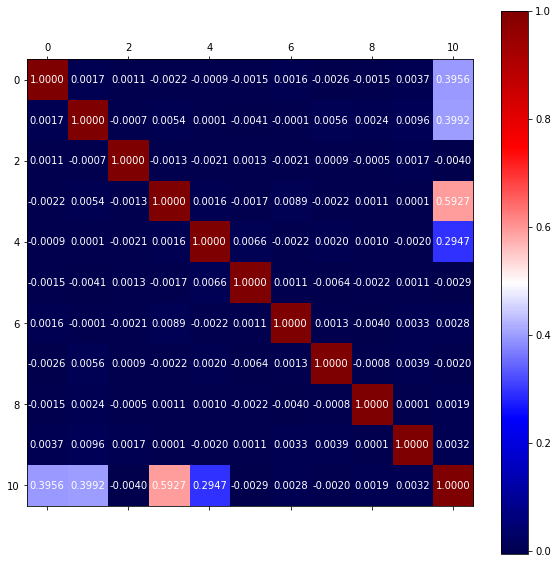

In [6]:
corr = df.corr().values
plot_corr(corr)

## Build Tree

Build trees and derive randomizations and see how their result behaves.

In [7]:
# Initialize
model = RegTree(max_depth=10)

# Fit
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

rmse_original = np.sqrt(np.mean((y_test - y_pred)**2))
rmse_original

1.8601042539423511

In [12]:
derived_trees = [model.randomize_tree() for _ in range(100)]
derived_pred = [m.predict(X_test) for m in derived_trees]
derived_rmse = [np.sqrt(np.mean((y_test - y_pred)**2)) for y_pred in derived_pred]
delta_rmse = [rmse_original-d for d in derived_rmse]

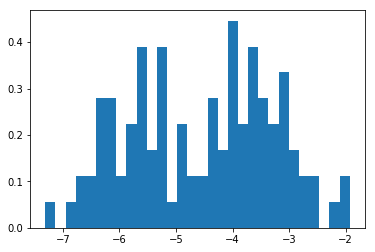

In [13]:
plt.hist(delta_rmse, 30, density=True)
plt.show()

In [18]:
derived_pred = np.array(derived_pred)
derived_pred.shape

(100, 20000)

In [26]:
mean_pred = np.mean(derived_pred, axis=0)
rmse_mean = np.sqrt(np.mean((y_test - mean_pred)**2))
rmse_mean

4.94776253312527

In [10]:
all_rmse = [rmse_original].extend(derived_rmse)